## Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time 
* Scheduled project review date/time: Monday, August 10th, 2020 - 2:45pm
* Instructor name: James Irving
* Blog post URL:


<img src='https://raw.githubusercontent.com/spags093/dsc-mod-1-project-v2-1-onl01-dtsc-ft-070620/master/microsoft%20studios.jpg'>

# Introduction

## Overview

Microsoft has recognized that other large tech corporations have found ample success in the film industry by producing their own original content.  The creation of the Microsoft Studios will create an entirely new revenue stream for the company as well as provide many opportunities to synergize with existing Microsoft products.  However, with a high-dollar point of entry and Microsoft's sterling reputation on the line, this can also prove to be a risky venture.  How can we minimize this risk and maximize the return on investment by using a data-driven production system?

Over the course of this notebook, we will answer the following questions:
 - Is there a correlation between a film's budget and it's performance at the box office?
 - Do films in certain genres perform better at the box office?  If so, which genres?
 - Is there a correlation between a film's MPAA rating and it's ROI?
 - Does a film's runtime have any affect on it's worldwide gross?


## Additional Notes

### Special Thanks

This analysis could not be done without the combined efforts of the P2P Study Group.  The data contained in imdb_money_ratings was scraped with 'test_requests.py' (found in the notebook) which was written by Sam Stoltenberg with the combined computing strength of the group.   

### List of Functions

In [1]:
# Gets info from the csv

def get_info (csv_name):
    print(csv_name.shape)
    print()
    print(csv_name.describe())
    print()
    print(csv_name.info())
    print()
    print(csv_name.isna().sum())


# Import and Clean Provided Datasets

In [2]:
!pip install -U plotly

Requirement already up-to-date: plotly in /Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages (4.9.0)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import requests
from bs4 import BeautifulSoup
import time
import plotly.express as px
import matplotlib.ticker as mtick
from scipy import stats

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Changes floats from scientific notation to more readable numbers. 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set dark background for Seaborn
plt.style.use("seaborn-darkgrid")

### Clean IMDB Title Basics CSV - CLEANED
This CSV contains basic information pertaining to films listed on IMDB, including title, genre, year released, and runtime.  Most importantly, it contains the 'tconst' column which is a unique code used by IMDB to organize their films.  This will be useful later in joining the different data sets. 

In [5]:
# Imported the CSV file

imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression = 'gzip')
imdb_title_basics_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


In [6]:
# Using a function to get basic data

get_info(imdb_title_basics_df)

(146144, 6)

       start_year  runtime_minutes
count   146144.00        114405.00
mean      2014.62            86.19
std          2.73           166.36
min       2010.00             1.00
25%       2012.00            70.00
50%       2015.00            87.00
75%       2017.00            99.00
max       2115.00         51420.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None

tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes  

In [7]:
# Finding the median of runtime_minutes

imdb_title_basics_df['runtime_minutes'].median()

87.0

In [8]:
# Replacing the null values in runtime_minutes with the median. (side note...not sure why I couldn't pass in the 
# code to get the median as the argument.

imdb_title_basics_df['runtime_minutes'].fillna(87.0, inplace = True)

In [9]:
#Finding the mode of 'genres'

imdb_title_basics_df['genres'].mode()

0    Documentary
dtype: object

In [10]:
#Filling the null values with the mode.

imdb_title_basics_df['genres'].fillna('Documentary', inplace = True)
#imdb_title_basics_df.head()

In [11]:
imdb_title_basics_df.dropna(axis = 0, inplace = True)

In [12]:
#imdb_title_basics_df.head()
print(imdb_title_basics_df.shape)

(146123, 6)


In [13]:
# Getting the value counts for each column to search for weirdness.

imdb_title_basics_columns = imdb_title_basics_df.columns
for column in imdb_title_basics_columns:
    display(imdb_title_basics_df[column].value_counts())

tt5930026    1
tt1896788    1
tt4484670    1
tt9452304    1
tt9106456    1
            ..
tt6020486    1
tt5069160    1
tt5442308    1
tt3527010    1
tt1870570    1
Name: tconst, Length: 146123, dtype: int64

Home                                    24
Broken                                  20
The Return                              20
Alone                                   16
Homecoming                              16
                                        ..
In Search of Voodoo: Roots to Heaven     1
Mona, tesoro del Caribe                  1
Searching for Katie                      1
Lobotomiya                               1
The Making of a Fatherless Daughter      1
Name: primary_title, Length: 136056, dtype: int64

Broken                                 19
Home                                   18
The Return                             17
The Gift                               13
Homecoming                             13
                                       ..
A Mulher de Longe                       1
The Dunning Man Soundtrack              1
Nhung Buc Thu Tu Son My                 1
One of Too Many: Part 3                 1
The Making of a Fatherless Daughter     1
Name: original_title, Length: 137773, dtype: int64

2017    17494
2016    17269
2018    16846
2015    16242
2014    15589
2013    14708
2012    13786
2011    12900
2010    11849
2019     8378
2020      936
2021       83
2022       32
2023        5
2024        2
2027        1
2026        1
2025        1
2115        1
Name: start_year, dtype: int64

87.00       33653
90.00        7131
80.00        3526
85.00        2915
100.00       2662
            ...  
396.00          1
382.00          1
14400.00        1
724.00          1
540.00          1
Name: runtime_minutes, Length: 367, dtype: int64

Documentary                       37574
Drama                             21486
Comedy                             9177
Horror                             4372
Comedy,Drama                       3519
                                  ...  
Comedy,Sport,Thriller                 1
History,Romance,Western               1
Crime,Fantasy,War                     1
Animation,Documentary,Thriller        1
Action,Horror,Music                   1
Name: genres, Length: 1085, dtype: int64

### Clean IMDB Title Ratings CSV - CLEANED
This CSV contains the user rating and vote numbers for each film listed.  Like earlier, this csv includes the 'tconst' column which will be used in a later merge.  


In [14]:
# Import the CSV

imdb_title_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression = 'gzip')
imdb_title_ratings_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


In [15]:
# Using a function to get basic informationa bout the dataframe.

get_info(imdb_title_ratings_df)

(73856, 3)

       averagerating   numvotes
count       73856.00   73856.00
mean            6.33    3523.66
std             1.47   30294.02
min             1.00       5.00
25%             5.50      14.00
50%             6.50      49.00
75%             7.40     282.00
max            10.00 1841066.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB
None

tconst           0
averagerating    0
numvotes         0
dtype: int64


In [16]:
# Getting an idea for the value counts to search for any weirdness.

imdb_title_ratings_columns = imdb_title_ratings_df.columns
for column in imdb_title_ratings_columns:
    display(imdb_title_ratings_df[column].value_counts())

tt1683919    1
tt2691690    1
tt1626184    1
tt6463494    1
tt5335682    1
            ..
tt2762506    1
tt2756188    1
tt2583942    1
tt7115980    1
tt1870570    1
Name: tconst, Length: 73856, dtype: int64

7.00     2262
6.60     2251
7.20     2249
6.80     2239
6.50     2221
         ... 
9.60       18
10.00      16
9.80       15
9.70       12
9.90        5
Name: averagerating, Length: 91, dtype: int64

6        2875
5        2699
7        2476
8        2167
9        1929
         ... 
18286       1
16289       1
1958        1
4007        1
4098        1
Name: numvotes, Length: 7349, dtype: int64

# Import Additional Data With Web Scraping 

## Box Office Results of Movie Franchises - FUTURE WORK

Address this in the future.  Link for scrape = https://www.the-numbers.com/movies/franchises#franchise_overview=od1

In [17]:
#franchise_page = requests.get('https://www.the-numbers.com/movies/franchises') 
#soup = BeautifulSoup(franchise_page.content, 'html.parser') 

In [18]:
#soup.prettify

In [19]:
# franchise_data = soup.findAll('table')
# franchise_data


In [20]:
#from html.parser import HTMLParser

In [21]:
# edited_franchise = franchise_data.text
# edited_franchise

## IMDB Scraped with Group

This scrape was a group effort with the core P2P study group team.  Each person took on a section of IMDB 'tconst' codes to scrape useful monetary and rating data.  The combined computing power allowed us to cut scrape time from 11 days down to around 9 hours.  To see the code for the scrape, please refer to 'test_requests.py'.

In [22]:
#Import the CSV

imdb_money_ratings = pd.read_csv('budget_ratings.csv')
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
0,0,tt2200832,nan,nan,nan,NotRated
1,1,tt2200860,nan,nan,1924766.00,NaN
2,2,tt2200908,nan,nan,105367.00,NaN
3,3,tt2200926,nan,nan,5784.00,NaN
4,4,tt2200955,nan,nan,nan,Comedy


In [23]:
# Get info on the csv using a function.

get_info(imdb_money_ratings)

(52943, 6)

       Unnamed: 0       budget        gross      ww_gross
count    52943.00     19396.00      6233.00      20921.00
mean     26471.00   6315791.47  17489603.72   16321566.20
std      15283.47  31223176.17  55195072.21   85632102.24
min          0.00         0.00        72.00          0.00
25%      13235.50      5000.00     24094.00      34829.00
50%      26471.00    186500.00    175232.00     327453.00
75%      39706.50   1000000.00   4033574.00    2935188.00
max      52942.00 900000000.00 936662225.00 2797800564.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52943 entries, 0 to 52942
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  52943 non-null  int64  
 1   tconst      52943 non-null  object 
 2   budget      19396 non-null  float64
 3   gross       6233 non-null   float64
 4   ww_gross    20921 non-null  float64
 5   rating      35743 non-null  object 
dtypes: float64(3), int64(1),

In [24]:
# Check the unique values within the ratings.  Uh oh...

imdb_money_ratings['rating'].unique()

array(['NotRated', nan, 'Comedy', 'Thriller', 'Documentary', 'R', 'TV-PG',
       'Family', 'PG-13', 'Drama,', 'TV-G', 'PG', 'Family,', 'Sci-Fi',
       'Comedy,', 'TV-MA', 'Biography,', 'Horror', 'G', 'Unrated',
       'Drama', 'Action', 'Romance', 'TV-14', 'Romance,', 'Sport',
       'Biography', 'Horror,', 'Action,', '27January2012(USA)',
       'TVMovie31October2010', 'Mystery', 'Crime,', 'Reality-TV',
       'History', 'Fantasy', 'TV-Y7', 'Animation,', '5May2012(USA)',
       'Music', 'Documentary,', 'Adventure,', 'TV-Y', 'Crime', 'NC-17',
       'Western', 'TV-Y7-FV', '2April2016(Japan)', 'Approved',
       '22March2012(Spain)', '19July2012(Portugal)', 'Adventure',
       'Musical', 'M', 'TVMovie21April2011', '12September2012(Poland)',
       'Animation', 'History,', 'TVMovie20April2012',
       '25April2014(Spain)', '5July2013(France)', 'Adult', 'Fantasy,',
       '25February2013(BurkinaFaso)', '7October2012(USA)', 'X',
       '23May2013(Argentina)', '12June2014(Italy)', 'War',


In [25]:
# Removed the junk data and replaced with NaN's.

ratings = ['M/PG', 'MA-17', 'X', 'M', 'C', 'T', 'E', 'E10+', 'TV-Y7-FV', 'NC-17', 'TV-Y',
           'TV-Y7', 'TV-14', 'G', 'TV-MA', 'PG', 'TV-G', 'PG-13', 'TV-PG', 'R']
for i in imdb_money_ratings['rating']:
    if i not in ratings:
        imdb_money_ratings['rating'].replace(i, np.nan, inplace=True)
    

In [26]:
imdb_money_ratings['rating'].unique()

array([nan, 'R', 'TV-PG', 'PG-13', 'TV-G', 'PG', 'TV-MA', 'G', 'TV-14',
       'TV-Y7', 'TV-Y', 'NC-17', 'TV-Y7-FV', 'M', 'X', 'E10+', 'E', 'C',
       'T', 'M/PG', 'MA-17'], dtype=object)

In [27]:
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
0,0,tt2200832,nan,nan,nan,NaN
1,1,tt2200860,nan,nan,1924766.00,NaN
2,2,tt2200908,nan,nan,105367.00,NaN
3,3,tt2200926,nan,nan,5784.00,NaN
4,4,tt2200955,nan,nan,nan,NaN


<h5> NOTE: </h5>
Tons of missing data in here.  Decided to whittle down from 52k listings to a smaller set that will represent ACCURATELY reported data from reputable studios.  Ran a check to make sure that this did not eliminate data on mainstream content (wide releases, blockbuster movies, noteworthy films, etc.)


In [28]:
#Dropping columns with missing information

imdb_money_ratings.dropna(axis = 0, inplace=True)
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
48,48,tt2203939,40000000.00,83911193.00,196710396.00,PG-13
67,67,tt2205401,5000000.00,17390770.00,17534314.00,R
73,73,tt2205591,100000.00,71737.00,71737.00,PG
92,92,tt2207006,10000000.00,110904.00,110904.00,PG-13
121,121,tt2209418,3000000.00,8114627.00,20994648.00,R


In [29]:
imdb_money_ratings.shape

(2225, 6)

In [30]:
imdb_money_ratings.head(10)

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
48,48,tt2203939,40000000.00,83911193.00,196710396.00,PG-13
67,67,tt2205401,5000000.00,17390770.00,17534314.00,R
73,73,tt2205591,100000.00,71737.00,71737.00,PG
92,92,tt2207006,10000000.00,110904.00,110904.00,PG-13
121,121,tt2209418,3000000.00,8114627.00,20994648.00,R
129,129,tt2209764,100000000.00,23022309.00,103039258.00,PG-13
209,209,tt2215077,270000000.00,54529.00,306393.00,R
223,223,tt2215285,20000000.00,65653242.00,66899242.00,PG-13
241,241,tt2215719,12000000.00,25326071.00,32726956.00,PG
249,249,tt2216240,500000.00,414437.00,2688444.00,R


# Join Data into Single Dataframe

In this section, I've first merged the imdb_title_basics_df & imdb_title_ratings_df.  Then, merged this new dataframe with the additional data scraped from IMDB.  This left me with one extremely useful dataframe representing 2225 films. 

## Merge Dataframes

In [31]:
#Merging the imdb_title_basics & imddb_title_ratings dataframes.

imdb_df = pd.merge(left=imdb_title_basics_df, right=imdb_title_ratings_df, how='left', left_on='tconst', right_on='tconst')
imdb_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama",7.00,77.00
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",7.20,43.00
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama,6.90,4517.00
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,87.00,"Comedy,Drama",6.10,13.00
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy",6.50,119.00


In [32]:
#Merging the resulting dataframe with the IMDB data that was scraped.  

imdb_full_df = pd.merge(left=imdb_money_ratings, right=imdb_df, how='left', left_on='tconst', right_on='tconst')
imdb_full_df.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,48,tt2203939,40000000.00,83911193.00,196710396.00,PG-13,The Other Woman,The Other Woman,2014.00,109.00,"Comedy,Romance",6.00,122889.00
1,67,tt2205401,5000000.00,17390770.00,17534314.00,R,Addicted,Addicted,2014.00,106.00,"Drama,Thriller",5.20,7640.00
2,73,tt2205591,100000.00,71737.00,71737.00,PG,Runaway Slave,Runaway Slave,2012.00,108.00,"Documentary,History",6.70,269.00
3,92,tt2207006,10000000.00,110904.00,110904.00,PG-13,The Obama Effect,The Obama Effect,2012.00,85.00,"Comedy,Drama",2.00,378.00
4,121,tt2209418,3000000.00,8114627.00,20994648.00,R,Before Midnight,Before Midnight,2013.00,109.00,"Drama,Romance",7.90,123107.00


In [33]:
# Dropped the old index column

imdb_full_df.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt2203939,40000000.00,83911193.00,196710396.00,PG-13,The Other Woman,The Other Woman,2014.00,109.00,"Comedy,Romance",6.00,122889.00
1,tt2205401,5000000.00,17390770.00,17534314.00,R,Addicted,Addicted,2014.00,106.00,"Drama,Thriller",5.20,7640.00
2,tt2205591,100000.00,71737.00,71737.00,PG,Runaway Slave,Runaway Slave,2012.00,108.00,"Documentary,History",6.70,269.00
3,tt2207006,10000000.00,110904.00,110904.00,PG-13,The Obama Effect,The Obama Effect,2012.00,85.00,"Comedy,Drama",2.00,378.00
4,tt2209418,3000000.00,8114627.00,20994648.00,R,Before Midnight,Before Midnight,2013.00,109.00,"Drama,Romance",7.90,123107.00


In [34]:
#Sorted the dataframe in descending order by worldwide gross.  

imdb_full_df.sort_values('ww_gross', ascending = False, inplace = True)

In [35]:
# Dropped the original title column.  Only want the most known titles. 

imdb_full_df.drop(labels = 'original_title', axis = 1, inplace = True)
print(imdb_full_df.shape)
imdb_full_df.head()

(2225, 11)


,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,"Action,Adventure,Sci-Fi",8.80,441135.00
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,"Action,Adventure,Fantasy",8.00,784780.00
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,"Action,Adventure,Sci-Fi",8.50,670926.00
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,"Action,Adventure,Sci-Fi",7.00,539338.00
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,"Adventure,Animation,Drama",nan,nan


## Analyze, Clean, and Alter Main Dataframe

In [36]:
# Adding a 'net revenue' column by subtracting the budget from the worldwide gross.  

imdb_full_df['Net_Revenue'] = imdb_full_df['ww_gross'] - imdb_full_df['budget']
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,Net_Revenue
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,"Action,Adventure,Sci-Fi",8.80,441135.00,2441800564.00
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,"Action,Adventure,Fantasy",8.00,784780.00,1823223624.00
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,"Action,Adventure,Sci-Fi",8.50,670926.00,1727359754.00
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,"Action,Adventure,Sci-Fi",7.00,539338.00,1520400637.00
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,"Adventure,Animation,Drama",nan,nan,1396943394.00


In [37]:
# Adding a 'ROI' column by dividing the net revenue with the budget

imdb_full_df['ROI'] = (imdb_full_df['Net_Revenue'] / imdb_full_df['budget']) * 100
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,Net_Revenue,ROI
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,"Action,Adventure,Sci-Fi",8.80,441135.00,2441800564.00,685.90
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,"Action,Adventure,Fantasy",8.00,784780.00,1823223624.00,744.17
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,"Action,Adventure,Sci-Fi",8.50,670926.00,1727359754.00,538.12
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,"Action,Adventure,Sci-Fi",7.00,539338.00,1520400637.00,1013.60
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,"Adventure,Animation,Drama",nan,nan,1396943394.00,537.29


In [38]:
# Dealing with the genres column being a single string listing multiple genres.  


In [39]:
#sum(imdb_full_df['genres'].isna())  #ran into a snag with some NaN's

In [40]:
imdb_full_df['genres'].mode()

0    Drama
dtype: object

In [41]:
imdb_full_df['genres'].fillna('Drama', inplace = True) #Fixed it

In [42]:
# Splitting the genre column into a list of separate strings

imdb_full_df['genre_list'] = imdb_full_df['genres'].apply(lambda x: x.split(','))
imdb_full_df['genre_list']


780       [Action, Adventure, Sci-Fi]
176      [Action, Adventure, Fantasy]
779       [Action, Adventure, Sci-Fi]
1164      [Action, Adventure, Sci-Fi]
2136    [Adventure, Animation, Drama]
                    ...              
247            [Comedy, Crime, Drama]
965                   [Comedy, Drama]
122                    [Crime, Drama]
1219         [Comedy, Drama, Romance]
712                       [Animation]
Name: genre_list, Length: 2225, dtype: object

In [43]:
# Removing pre-existing genres column. 

imdb_full_df.drop('genres', axis = 1, inplace = True)
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,averagerating,numvotes,Net_Revenue,ROI,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,8.80,441135.00,2441800564.00,685.90,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,8.00,784780.00,1823223624.00,744.17,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,8.50,670926.00,1727359754.00,538.12,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,7.00,539338.00,1520400637.00,1013.60,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,nan,nan,1396943394.00,537.29,"[Adventure, Animation, Drama]"


In [44]:
# removing columns I'm not using. 

imdb_full_df.drop('averagerating', axis = 1, inplace = True)
imdb_full_df.drop('numvotes', axis = 1, inplace = True)
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,Net_Revenue,ROI,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,2441800564.00,685.90,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,1823223624.00,744.17,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,1727359754.00,538.12,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,1520400637.00,1013.60,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,1396943394.00,537.29,"[Adventure, Animation, Drama]"


<b><i>Note:</b></i> 
Since we're looking to create a film studio that can compete with other large film companies, we must assume that movies will not be made with budgets under 1 million dollars, which is the Hollywood standard for a low-budget movie. (Most major studios consider $30 million to be low budget!)

In [45]:
# remove movies where budget falls under $1 million. 

imdb_full_df = imdb_full_df[imdb_full_df['budget'] >= 1000000]  

        
imdb_full_df.shape

(1968, 11)

In [46]:
imdb_full_df.tail()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,Net_Revenue,ROI,genre_list
164,tt2460506,2100000.00,3330.00,3330.00,R,Mi America,2015.00,90.00,-2096670.00,-99.84,"[Crime, Drama]"
502,tt5143890,18000000.00,3259.00,3259.00,R,Justice,2017.00,92.00,-17996741.00,-99.98,[Western]
130,tt2387589,28000000.00,3124.00,3124.00,R,The Girl on the Train,2013.00,80.00,-27996876.00,-99.99,[Thriller]
965,tt1885300,1500000.00,1938.00,1938.00,PG-13,Best Man Down,2012.00,89.00,-1498062.00,-99.87,"[Comedy, Drama]"
1219,tt0762138,2500000.00,663.00,663.00,R,Syrup,2013.00,90.00,-2499337.00,-99.97,"[Comedy, Drama, Romance]"


The final dataframe contains informationf or 1968 films.

# Analysis

## Q1. Is there a correlation between a film's budget and it's performance at the box office?

In [47]:
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,Net_Revenue,ROI,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,2441800564.00,685.90,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,1823223624.00,744.17,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,1727359754.00,538.12,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,1520400637.00,1013.60,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,1396943394.00,537.29,"[Adventure, Animation, Drama]"


In [48]:
# Creating a smaller dataframe with title, budget, and net revenue.

budget_roi_df = imdb_full_df.loc[:, ['primary_title', 'budget', 'Net_Revenue', 'ROI', 'ww_gross']]
budget_roi_df.head()
                                 

,primary_title,budget,Net_Revenue,ROI,ww_gross
780,Avengers: Endgame,356000000.00,2441800564.00,685.90,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,245000000.00,1823223624.00,744.17,2068223624.00
779,Avengers: Infinity War,321000000.00,1727359754.00,538.12,2048359754.00
1164,Jurassic World,150000000.00,1520400637.00,1013.60,1670400637.00
2136,The Lion King,260000000.00,1396943394.00,537.29,1656943394.00


In [49]:
budget_roi_df.describe()

,budget,Net_Revenue,ROI,ww_gross
count,1968.00,1968.00,1968.00,1968.00
mean,42263441.46,94500947.26,235.37,136764388.72
std,52814726.44,202951502.27,550.83,241492763.70
min,1000000.00,-297460960.00,-99.99,663.00
25%,8500000.00,-1911619.25,-31.38,8156312.00
50%,21000000.00,21635963.50,107.28,47198321.50
75%,50000000.00,95508765.75,303.21,149306619.00
max,356000000.00,2441800564.00,10075.85,2797800564.00


In [50]:
#Checking the correlation between budget and revenue. 

budget_roi_df.corr()

,budget,Net_Revenue,ROI,ww_gross
budget,1.00,0.67,-0.02,0.78
Net_Revenue,0.67,1.00,0.29,0.99
ROI,-0.02,0.29,1.00,0.24
ww_gross,0.78,0.99,0.24,1.00


In [51]:
# Dropping 5 films with NaN's for title. 

budget_roi_df = budget_roi_df.dropna()

In [52]:
# Sorting by worldwide gross

budget_roi_df = budget_roi_df.sort_values('ww_gross', ascending = False) 
budget_roi_df.head()

,primary_title,budget,Net_Revenue,ROI,ww_gross
780,Avengers: Endgame,356000000.00,2441800564.00,685.90,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,245000000.00,1823223624.00,744.17,2068223624.00
779,Avengers: Infinity War,321000000.00,1727359754.00,538.12,2048359754.00
1164,Jurassic World,150000000.00,1520400637.00,1013.60,1670400637.00
2136,The Lion King,260000000.00,1396943394.00,537.29,1656943394.00


In [53]:
budget_roi_df.shape

(1964, 5)

In [54]:
budget_roi_df['budget'].describe()

count        1964.00
mean     42323041.14
std      52845338.21
min       1000000.00
25%       8500000.00
50%      21000000.00
75%      50000000.00
max     356000000.00
Name: budget, dtype: float64

In [55]:
budget_roi_df['ROI'].describe()

count    1964.00
mean      235.81
std       551.26
min       -99.99
25%       -31.25
50%       107.59
75%       303.60
max     10075.85
Name: ROI, dtype: float64

### Fig. 1 - Budget vs. Revenue
In the figure below, the goal is to see if there exists a "sweet spot" in terms of a production budget where we can maximize the rate of return.  The top 100 highest grossing films are represented and the larger the plot point, the higher the net profit.  As we can see, outside of a handful of "home runs", the area of the most consistent rate of return is where <b> the production budget falls between 150 and 200 million dollars. </b>

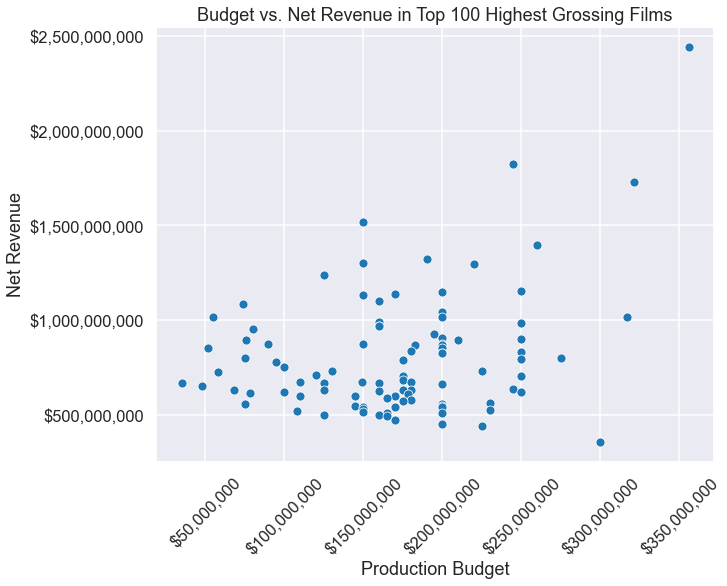

In [126]:
#Created a scatter plot showing the relationhip between budget and revenue across the top 100 highest grossing films.

f,ax = plt.subplots(figsize = (10,8))
ax = sns.set_context("talk")
ax = sns.set_style("darkgrid")
ax = sns.scatterplot(x = 'budget', y = 'Net_Revenue', ci = 68, data = budget_roi_df.head(100));
ax.ticklabel_format(style='plain')
ax.set_title('Budget vs. Net Revenue in Top 100 Highest Grossing Films')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Net Revenue')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.xaxis.set_major_formatter(tick)
plt.xticks(rotation = 45);


In [57]:
# Z Score Experiment - Carry on
# z = np.abs(stats.zscore(budget_roi_df['budget']))
# too_low_budget = z > 3 
# budget_roi_df.loc[too_low_budget]

In [58]:
# Crudely filtering the budgets to range between 150 and 200 million - part 1 

budget_roi_df_new = budget_roi_df[budget_roi_df['budget'] >= 150000000]
budget_roi_df_new.shape

(142, 5)

In [59]:
# Crudely filtering the budgets to range between 150 and 200 million - part 2 

budget_roi_df_new = budget_roi_df_new[budget_roi_df_new['budget'] <= 200000000]
budget_roi_df_new.shape

(111, 5)

In [60]:
# Sort by ROI

budget_roi_df_new = budget_roi_df_new.sort_values('ROI', ascending = False) 
budget_roi_df_new

,primary_title,budget,Net_Revenue,ROI,ww_gross
1164,Jurassic World,150000000.00,1520400637.00,1013.60,1670400637.00
395,Frozen II,150000000.00,1300026933.00,866.68,1450026933.00
53,Frozen,150000000.00,1130802282.00,753.87,1280802282.00
268,Furious 7,190000000.00,1325048151.00,697.39,1515048151.00
255,Beauty and the Beast,160000000.00,1103536328.00,689.71,1263536328.00
...,...,...,...,...,...
1227,The Wolfman,150000000.00,-10210235.00,-6.81,139789765.00
1585,47 Ronin,175000000.00,-23216161.00,-13.27,151783839.00
610,Pan,150000000.00,-21611680.00,-14.41,128388320.00
1024,King Arthur: Legend of the Sword,175000000.00,-26324934.00,-15.04,148675066.00


In [61]:
budget_roi_df_new.loc[budget_roi_df_new['budget'] == 195000000.00]

,primary_title,budget,Net_Revenue,ROI,ww_gross
1639,Transformers: Dark of the Moon,195000000.00,928794079.00,476.30,1123794079.00
1596,Jack the Giant Slayer,195000000.00,2687603.00,1.38,197687603.00


### Fig 2. - Production Budget vs. ROI in 150-200 Million Dollar Budgets 
After figuring out that the budget "sweet spot" is between 150 and 200 million dollars, I wanted to see if I could narrow that range down a bit and figure out a more exact number.  I now want to compare the ROI of films with budgets between 150 & 200 milliion dollars.  We can now see that <b>the single budget that has the highest ROI within this range is $183 million. </b>

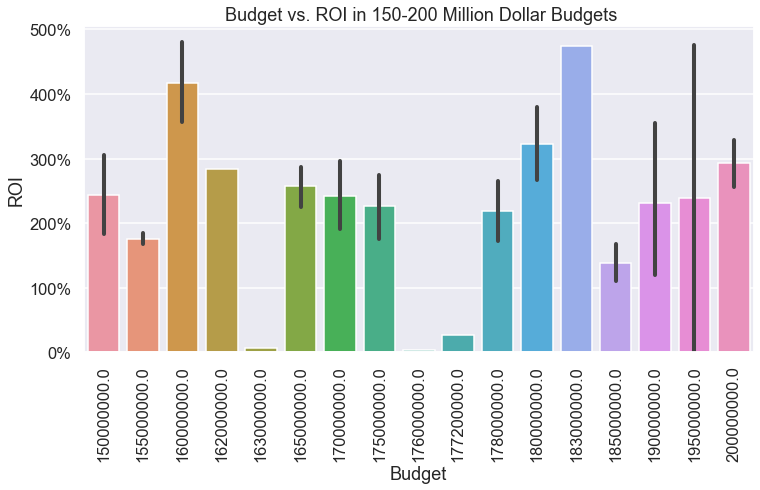

In [62]:
# I want to get a little tighter of a scope as far as optimal budget.

f,ax = plt.subplots(figsize = (12,6))
ax = sns.set_style("darkgrid")
ax = sns.set_context("talk")
ax = sns.barplot(x = 'budget', y = 'ROI', data = budget_roi_df_new, ci = 68)
ax.set_title(' Budget vs. ROI in 150-200 Million Dollar Budgets')
ax.set_xlabel('Budget')
ax.set_ylabel('ROI')

#fmt = '${x:,.0f}'
fmt2 = '{x:,.0f}%'
#tick1 = mtick.StrMethodFormatter(fmt)
tick2 = mtick.StrMethodFormatter(fmt2)
ax.yaxis.set_major_formatter(tick2)
#ax.xaxis.set_major_formatter(tick)
plt.xticks(rotation = 90);


In [63]:
#Creating another small dataframe

genre_budget_df = imdb_full_df.loc[:, ['budget', 'genre_list']]
genre_budget_df.head()

,budget,genre_list
780,356000000.00,"[Action, Adventure, Sci-Fi]"
176,245000000.00,"[Action, Adventure, Fantasy]"
779,321000000.00,"[Action, Adventure, Sci-Fi]"
1164,150000000.00,"[Action, Adventure, Sci-Fi]"
2136,260000000.00,"[Adventure, Animation, Drama]"


In [64]:
#Explode genres

genre_budget_df = genre_budget_df.explode('genre_list')
genre_budget_df.head()

,budget,genre_list
780,356000000.00,Action
780,356000000.00,Adventure
780,356000000.00,Sci-Fi
176,245000000.00,Action
176,245000000.00,Adventure


In [65]:
#Group by genre list and calculate median budgets. 

genre_budget_df = genre_budget_df.groupby('genre_list')['budget'].median()

In [66]:
# Put the series back into a dataframe

genre_budget_df = genre_budget_df.to_frame(name = 'budget').reset_index()

In [67]:
# Sort by budget 

genre_budget_df = genre_budget_df.sort_values('budget', ascending = False) 

In [68]:
genre_budget_df.head()

,genre_list,budget
1,Adventure,90000000.00
2,Animation,76000000.00
17,Sci-Fi,66500000.00
9,Fantasy,60000000.00
13,Musical,58000000.00


### Fig. 3 - Median Budget by Genre
We'll talk more about genre in the next section, but the figure below shows the median budget by genre of films produced over the last 10 years.  <b>We can see that Adventure, Animation, and Sci Fi are among the most expensive films to make.</b>

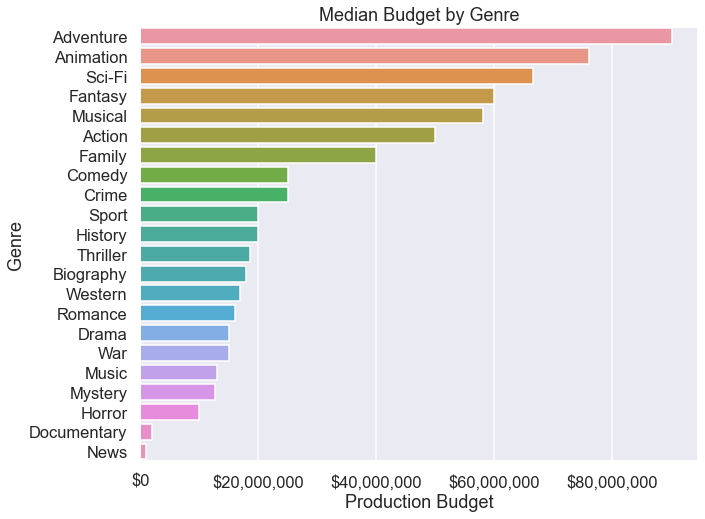

In [69]:
ax = plt.figure(figsize = (10,8))
ax = sns.set_style("darkgrid")
ax = sns.set_context("talk")
ax = sns.barplot(x = 'budget', y = 'genre_list', data = genre_budget_df)
ax.set_title('Median Budget by Genre')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Genre')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick);

## Q2. Do movies in certain genres perform better at the box office?

In [70]:
# Creating a smaller dataframe to work with.  Using just title, genre, and net revenue. 

genre_revenue_df = imdb_full_df.loc[:, ['primary_title', 'genre_list', 'Net_Revenue', 'ROI', 'ww_gross']]
genre_revenue_df.head()

,primary_title,genre_list,Net_Revenue,ROI,ww_gross
780,Avengers: Endgame,"[Action, Adventure, Sci-Fi]",2441800564.00,685.90,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,"[Action, Adventure, Fantasy]",1823223624.00,744.17,2068223624.00
779,Avengers: Infinity War,"[Action, Adventure, Sci-Fi]",1727359754.00,538.12,2048359754.00
1164,Jurassic World,"[Action, Adventure, Sci-Fi]",1520400637.00,1013.60,1670400637.00
2136,The Lion King,"[Adventure, Animation, Drama]",1396943394.00,537.29,1656943394.00


In [71]:
# Giving each listed genre it's own row, as many films have multiple genres. 

genre_revenue_df = genre_revenue_df.explode('genre_list')
genre_revenue_df

,primary_title,genre_list,Net_Revenue,ROI,ww_gross
780,Avengers: Endgame,Action,2441800564.00,685.90,2797800564.00
780,Avengers: Endgame,Adventure,2441800564.00,685.90,2797800564.00
780,Avengers: Endgame,Sci-Fi,2441800564.00,685.90,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,Action,1823223624.00,744.17,2068223624.00
176,Star Wars: Episode VII - The Force Awakens,Adventure,1823223624.00,744.17,2068223624.00
...,...,...,...,...,...
965,Best Man Down,Comedy,-1498062.00,-99.87,1938.00
965,Best Man Down,Drama,-1498062.00,-99.87,1938.00
1219,Syrup,Comedy,-2499337.00,-99.97,663.00
1219,Syrup,Drama,-2499337.00,-99.97,663.00


In [72]:
genre_revenue_df.nunique()

primary_title    1960
genre_list         22
Net_Revenue      1968
ROI              1968
ww_gross         1967
dtype: int64

In [73]:
genre_revenue_df.isna().sum()

primary_title    4
genre_list       0
Net_Revenue      0
ROI              0
ww_gross         0
dtype: int64

In [74]:
# Drop remaining null values 

genre_revenue_df.dropna()

,primary_title,genre_list,Net_Revenue,ROI,ww_gross
780,Avengers: Endgame,Action,2441800564.00,685.90,2797800564.00
780,Avengers: Endgame,Adventure,2441800564.00,685.90,2797800564.00
780,Avengers: Endgame,Sci-Fi,2441800564.00,685.90,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,Action,1823223624.00,744.17,2068223624.00
176,Star Wars: Episode VII - The Force Awakens,Adventure,1823223624.00,744.17,2068223624.00
...,...,...,...,...,...
965,Best Man Down,Comedy,-1498062.00,-99.87,1938.00
965,Best Man Down,Drama,-1498062.00,-99.87,1938.00
1219,Syrup,Comedy,-2499337.00,-99.97,663.00
1219,Syrup,Drama,-2499337.00,-99.97,663.00


In [75]:
# Filtering the info further by dropping the title, giving me just the genre and how much money earned. 

genre_revenue_df.drop('primary_title', axis = 1, inplace = True)
genre_revenue_df.head()

,genre_list,Net_Revenue,ROI,ww_gross
780,Action,2441800564.00,685.90,2797800564.00
780,Adventure,2441800564.00,685.90,2797800564.00
780,Sci-Fi,2441800564.00,685.90,2797800564.00
176,Action,1823223624.00,744.17,2068223624.00
176,Adventure,1823223624.00,744.17,2068223624.00


In [76]:
# Sorting by worldwide gross in descending order.

genre_revenue_df = genre_revenue_df.sort_values('ww_gross', ascending = False) 
genre_revenue_df.head()

,genre_list,Net_Revenue,ROI,ww_gross
780,Action,2441800564.00,685.90,2797800564.00
780,Sci-Fi,2441800564.00,685.90,2797800564.00
780,Adventure,2441800564.00,685.90,2797800564.00
176,Action,1823223624.00,744.17,2068223624.00
176,Fantasy,1823223624.00,744.17,2068223624.00


In [77]:
# Creating one last dataframe that combines all films of a specific genre and adds their net revenue.

final_genre_revenue_df = genre_revenue_df.groupby('genre_list')['Net_Revenue'].median()

In [78]:
final_genre_revenue_df

genre_list
Action         55366737.00
Adventure     120953723.00
Animation     134040103.00
Biography       8189571.50
Comedy         29779728.00
Crime           7753365.00
Documentary     -107198.00
Drama           7553763.00
Family         52744032.50
Fantasy        51921761.00
History         1478892.50
Horror         33854305.00
Music           9122090.00
Musical        17673631.00
Mystery        33036609.00
News            -107198.00
Romance        12332018.50
Sci-Fi        111937877.50
Sport            698679.00
Thriller       26020018.50
War            -1315295.00
Western        -3081122.50
Name: Net_Revenue, dtype: float64

In [79]:
#change from groupby back into a dataframe
final_genre_revenue_df = final_genre_revenue_df.to_frame(name = 'Net_Revenue').reset_index()

In [80]:
final_genre_revenue_df = final_genre_revenue_df.sort_values('Net_Revenue', ascending = False) 

In [81]:
final_genre_revenue_df

,genre_list,Net_Revenue
2,Animation,134040103.00
1,Adventure,120953723.00
17,Sci-Fi,111937877.50
0,Action,55366737.00
8,Family,52744032.50
9,Fantasy,51921761.00
11,Horror,33854305.00
14,Mystery,33036609.00
4,Comedy,29779728.00
19,Thriller,26020018.50


### Fig. 4 - Median Net Revenue by Genre
The figure below represents the total net revenue for each major genre over the past 10 years.  We can see that <b>the genres with the highest median net revenue are Sci Fi, Adventure, Fantasy, Musical and Animation. </b>  

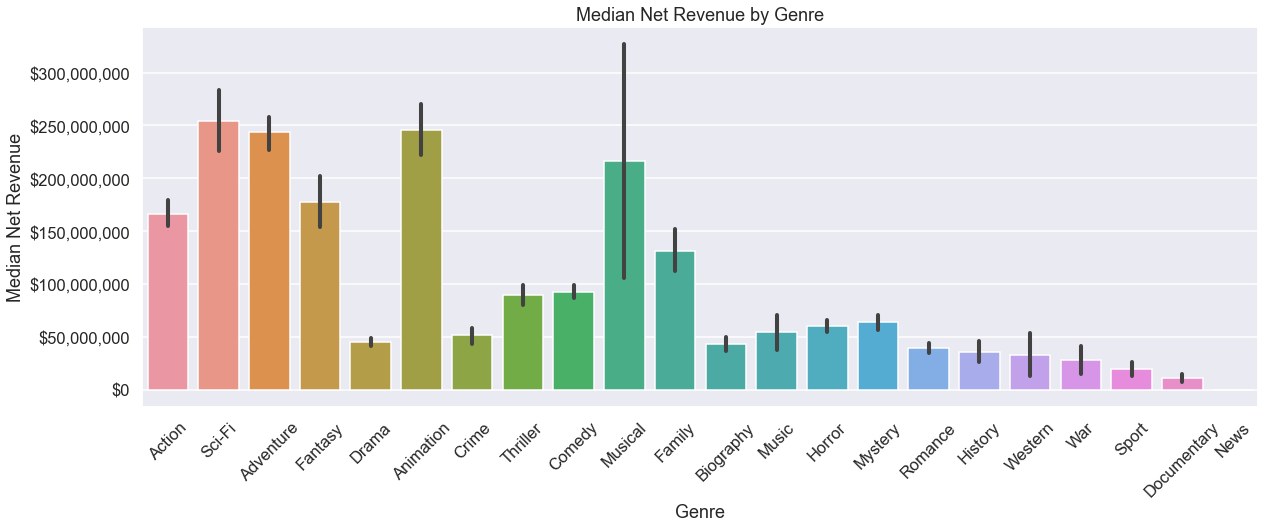

In [127]:
ax = plt.figure(figsize = (20,7))
ax = sns.set_context("talk")
ax = sns.set_style("darkgrid")
ax = sns.barplot(x = 'genre_list', y = 'Net_Revenue', data = genre_revenue_df, ci = 68 );
ax.set_title('Median Net Revenue by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Median Net Revenue')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xticks(rotation = 45);


In [83]:
# New dataframe of genres and median ROI
genre_roi_df = genre_revenue_df.groupby('genre_list')['ROI'].median()

In [84]:
genre_roi_df = genre_roi_df.to_frame(name = 'ROI').reset_index()

In [85]:
# Sort dataframe by ROI
genre_roi_df = genre_roi_df.sort_values('ROI', ascending = False) 

In [86]:
#Created a plot representing the ROI by genre. Not important.

# plt.figure(figsize = (20,7))
# sns.set_context("talk")
# #with sns.plotting_context(font_scale = 1):
# ax = sns.barplot(x = 'genre_list', y = 'ROI', data = genre_revenue_df, ci = 68)
# ax.set_title('ROI by Genre')
# ax.set_xlabel('Genre')
# ax.set_ylabel('Median ROI')


# fmt = '{x:,.0f}%'
# tick = mtick.StrMethodFormatter(fmt)
# ax.yaxis.set_major_formatter(tick) 
# plt.xticks(rotation=45);

In [87]:
# Creating a dataframe of the top 5 genre's by revenue to compare ROI

top_genre_roi_df1 = genre_roi_df.loc[genre_roi_df['genre_list'] == 'Adventure']
top_genre_roi_df2 = genre_roi_df.loc[genre_roi_df['genre_list'] == 'Sci-Fi']
top_genre_roi_df3 = genre_roi_df.loc[genre_roi_df['genre_list'] == 'Animation']
top_genre_roi_df4 = genre_roi_df.loc[genre_roi_df['genre_list'] == 'Musical']
top_genre_roi_df5 = genre_roi_df.loc[genre_roi_df['genre_list'] == 'Fantasy']

top_genre_roi_df = pd.concat([top_genre_roi_df1, top_genre_roi_df2, top_genre_roi_df3, 
                              top_genre_roi_df4, top_genre_roi_df5])

top_genre_roi_df

,genre_list,ROI
1,Adventure,168.43
17,Sci-Fi,161.74
2,Animation,191.34
13,Musical,52.07
9,Fantasy,128.07


### Fig. 5 - ROI of Top 5 Most Profitable Genres
After seeing that the top 5 genres by net revenue are Adventure, Sci-Fi, Animation, Musical, and Fantasy, I wanted to check the ROI across these 5 genres.  Surprisingly, <b>of these genres, Animation has the highest ROI.<b>

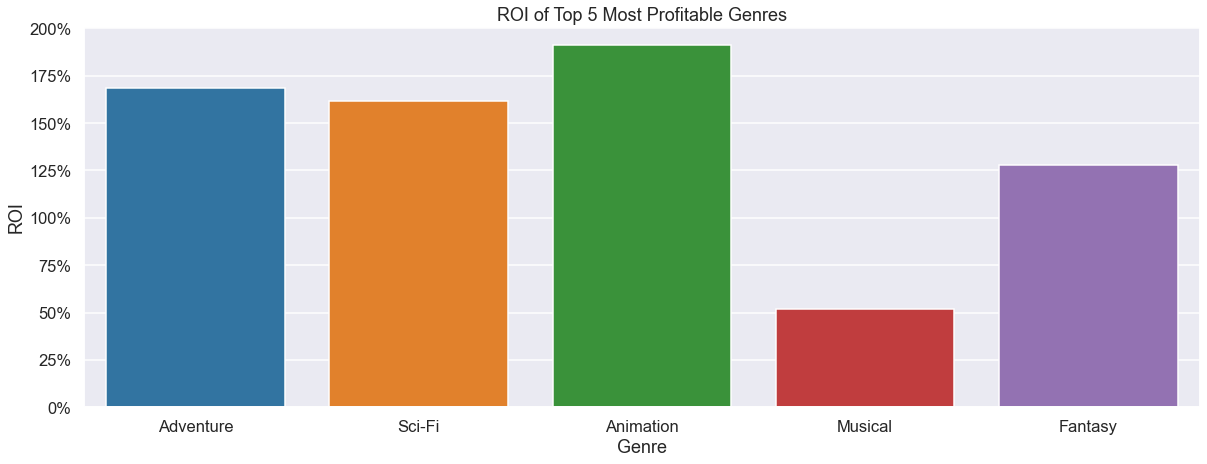

In [88]:
ax = plt.figure(figsize = (20,7))
ax = sns.set_context("talk")
ax = sns.set_style("darkgrid")
ax = sns.barplot(x = 'genre_list', y = 'ROI', data = top_genre_roi_df, ci = 68)
ax.set_title('ROI of Top 5 Most Profitable Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI')


fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick);

## Q3. What is the relationship between a film's MPAA rating and it's performance at the box office?

In [89]:
# Created smaller rating dataframe.

rating_revenue_df = imdb_full_df.loc[:, ['primary_title', 'rating', 'Net_Revenue', 'ww_gross', 'ROI']]
rating_revenue_df.head()

,primary_title,rating,Net_Revenue,ww_gross,ROI
780,Avengers: Endgame,PG-13,2441800564.00,2797800564.00,685.90
176,Star Wars: Episode VII - The Force Awakens,PG-13,1823223624.00,2068223624.00,744.17
779,Avengers: Infinity War,PG-13,1727359754.00,2048359754.00,538.12
1164,Jurassic World,PG-13,1520400637.00,1670400637.00,1013.60
2136,The Lion King,PG,1396943394.00,1656943394.00,537.29


In [90]:
# Checked the value counts.  Ew there's still TV ratings.

rating_revenue_df['rating'].value_counts()

R        869
PG-13    764
PG       289
G         26
TV-MA     12
TV-14      6
NC-17      1
TV-PG      1
Name: rating, dtype: int64

In [91]:
# Removing irrelevant ratings

ratings_list = ['R', 'PG-13', 'PG', 'G', 'NC-17']
for i in rating_revenue_df['rating']:
    if i not in ratings_list:
        rating_revenue_df['rating'].replace(i, np.nan, inplace=True)
    
rating_revenue_df['rating'].value_counts()

R        869
PG-13    764
PG       289
G         26
NC-17      1
Name: rating, dtype: int64

<h5> Note: </h5>
While this seems weird to keep movies with TV ratings, each of those listings does have a box office gross.  Upon further research, I learned that movies produced for television can open theatrically in some cases.  However, for the purposes of this analysis, I want to make the assumption that Microsoft will not be producing films for television.  For more information, <a href="https://help.imdb.com/article/imdb/discover-watch/how-do-you-decide-if-a-title-is-a-film-a-tv-movie-or-a-miniseries/GKUQEMEFSM54T2KT?ref_=helpart_nav_21#"> click here.</a> 


In [92]:
#Getting an overview of info using the function...again.

get_info(rating_revenue_df)

(1968, 5)

        Net_Revenue      ww_gross      ROI
count       1968.00       1968.00  1968.00
mean    94500947.26  136764388.72   235.37
std    202951502.27  241492763.70   550.83
min   -297460960.00        663.00   -99.99
25%     -1911619.25    8156312.00   -31.38
50%     21635963.50   47198321.50   107.28
75%     95508765.75  149306619.00   303.21
max   2441800564.00 2797800564.00 10075.85

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 780 to 1219
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_title  1964 non-null   object 
 1   rating         1949 non-null   object 
 2   Net_Revenue    1968 non-null   float64
 3   ww_gross       1968 non-null   float64
 4   ROI            1968 non-null   float64
dtypes: float64(3), object(2)
memory usage: 92.2+ KB
None

primary_title     4
rating           19
Net_Revenue       0
ww_gross          0
ROI               0
dtype: int64


In [93]:
# Getting the mode of rating_revenue_df.

rating_revenue_df['rating'].mode()


0    R
dtype: object

In [94]:
# Filling the nan's with the mode.

rating_revenue_df['rating'].fillna('R', inplace = True)

In [95]:
# Dropping the titles from the dataframe. 

rating_revenue_df.drop('primary_title', axis = 1, inplace = True)

In [96]:
rating_revenue_df.head()

,rating,Net_Revenue,ww_gross,ROI
780,PG-13,2441800564.00,2797800564.00,685.90
176,PG-13,1823223624.00,2068223624.00,744.17
779,PG-13,1727359754.00,2048359754.00,538.12
1164,PG-13,1520400637.00,1670400637.00,1013.60
2136,PG,1396943394.00,1656943394.00,537.29


In [97]:
# Grouping the each instance of the rating into a single value and adding the net revenues. 
# Then turning it back from a series to a dataframe. 

final_rating_revenue_df = rating_revenue_df.groupby('rating')['Net_Revenue'].median()
final_rating_revenue_df.to_frame(name = 'Net_Revenue').reset_index()



,rating,Net_Revenue
0,G,27840755.50
1,NC-17,12623767.00
2,PG,58943453.00
3,PG-13,35347211.50
4,R,6129757.50


In [98]:
type(final_rating_revenue_df)

pandas.core.series.Series

In [99]:
type(final_genre_revenue_df)

pandas.core.frame.DataFrame

In [100]:
final_rating_revenue_df.to_frame()

,Net_Revenue
rating,
G,27840755.50
NC-17,12623767.00
PG,58943453.00
PG-13,35347211.50
R,6129757.50


In [101]:
final_rating_revenue_df

rating
G       27840755.50
NC-17   12623767.00
PG      58943453.00
PG-13   35347211.50
R        6129757.50
Name: Net_Revenue, dtype: float64

In [102]:
# Took a second, but figured out how to get it to be a dataframe. 

final_rating_revenue_df = final_rating_revenue_df.to_frame(name = 'Net_Revenue').reset_index()
type(final_rating_revenue_df)

pandas.core.frame.DataFrame

In [103]:
# Sorting the dataframe by Net Revenue

final_rating_revenue_df = final_rating_revenue_df.sort_values('Net_Revenue', ascending = False) 

In [104]:
final_rating_revenue_df

,rating,Net_Revenue
2,PG,58943453.00
3,PG-13,35347211.50
0,G,27840755.50
1,NC-17,12623767.00
4,R,6129757.50


In [105]:
# Trying a few different plots
#px.box(data_frame = rating_revenue_df, x = 'rating', y = 'Net_Revenue')

### Fig. 6 - Median Net Revenue by Rating
The figure below represents the median net revenue of movies with particular MPAA ratings over the last 10 years.  <b> Films that are rated PG make up a large portion of the total profits of the entire film industry.</b>  

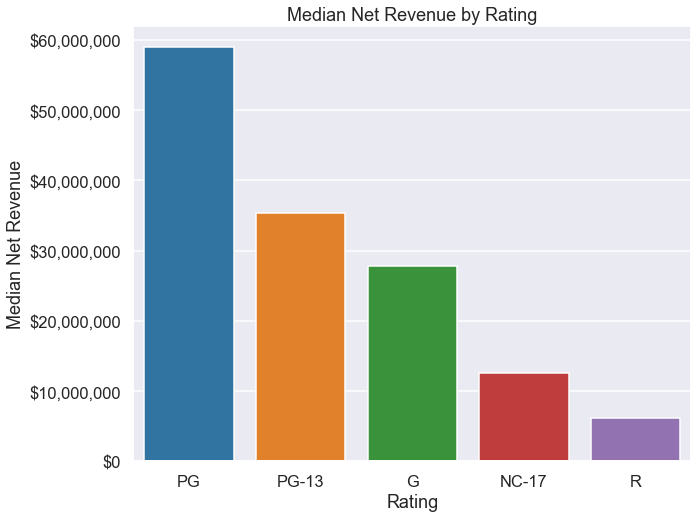

In [106]:
#Plotting out this information on a bar plot. 
ax = sns.set_style("darkgrid")
ax = plt.figure(figsize = (10,8))
ax = sns.set_context("talk")
ax = sns.barplot(x = 'rating', y = 'Net_Revenue', data = final_rating_revenue_df, ci = 68)
ax.set_title('Median Net Revenue by Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Median Net Revenue');

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

In [107]:
rating_roi_df = rating_revenue_df.groupby('rating')['ROI'].mean()

In [108]:
rating_roi_df = rating_roi_df.to_frame(name = 'ROI').reset_index()

In [109]:
rating_roi_df = rating_roi_df.sort_values('ROI', ascending = False) 
rating_roi_df

,rating,ROI
0,G,247.89
2,PG,244.83
3,PG-13,235.92
4,R,231.50
1,NC-17,194.21


### Fig. 7 - Average ROI by Rating
In terms of return on investment, we can see that <b>there's little difference in the average ROI between G, PG, PG-13 and R rated movies </b> with G rated movies edging out the others in this category.  Therefore, <b>we can still say that making a PG rated movie is the safest bet. </b>

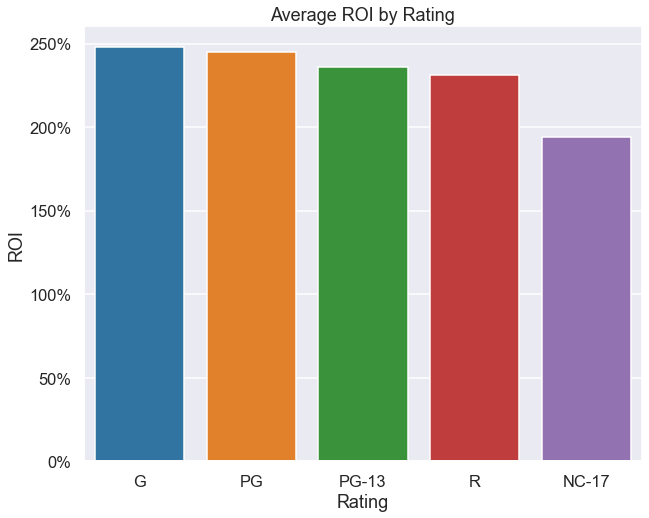

In [110]:
plt.figure(figsize = (10,8))
ax = sns.set_context("talk")
ax = sns.set_style("darkgrid")
ax = sns.barplot(x = 'rating', y = 'ROI', data = rating_roi_df, ci = 68)
ax.set_title('Average ROI by Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('ROI')


fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
#plt.xticks(rotation=45);

## Q4. Does the length of a film affect the worldwide gross? 

In [111]:
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,Net_Revenue,ROI,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,2441800564.00,685.90,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,1823223624.00,744.17,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,1727359754.00,538.12,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,1520400637.00,1013.60,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,1396943394.00,537.29,"[Adventure, Animation, Drama]"


In [112]:
#Creating a separate dataframe with specific columns. 

runtime_gross_df = imdb_full_df.loc[:, ['primary_title', 'runtime_minutes', 'ww_gross', 'ROI', 'Net_Revenue']]
runtime_gross_df.head()

,primary_title,runtime_minutes,ww_gross,ROI,Net_Revenue
780,Avengers: Endgame,181.00,2797800564.00,685.90,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,136.00,2068223624.00,744.17,1823223624.00
779,Avengers: Infinity War,149.00,2048359754.00,538.12,1727359754.00
1164,Jurassic World,124.00,1670400637.00,1013.60,1520400637.00
2136,The Lion King,87.00,1656943394.00,537.29,1396943394.00


In [113]:
#Checking for nan's

runtime_gross_df.isna().sum()

primary_title      4
runtime_minutes    4
ww_gross           0
ROI                0
Net_Revenue        0
dtype: int64

In [114]:
# Dropping a few without a title. 
runtime_gross_df = runtime_gross_df.dropna()


In [115]:
# Sorting the films by runtime 

runtime_gross_df = runtime_gross_df.sort_values('ww_gross', ascending = False) 
runtime_gross_df.head()

,primary_title,runtime_minutes,ww_gross,ROI,Net_Revenue
780,Avengers: Endgame,181.00,2797800564.00,685.90,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,136.00,2068223624.00,744.17,1823223624.00
779,Avengers: Infinity War,149.00,2048359754.00,538.12,1727359754.00
1164,Jurassic World,124.00,1670400637.00,1013.60,1520400637.00
2136,The Lion King,87.00,1656943394.00,537.29,1396943394.00


### Fig. 8 - Runtime Histogram
The histogram below shows the range of the runtime of all the movies in the dataset.  We can see that the runtime of most films falls between 80 minutes and 140 minutes with a mean of 107 minutes. 

In [116]:
round(runtime_gross_df['runtime_minutes'].mean())

107

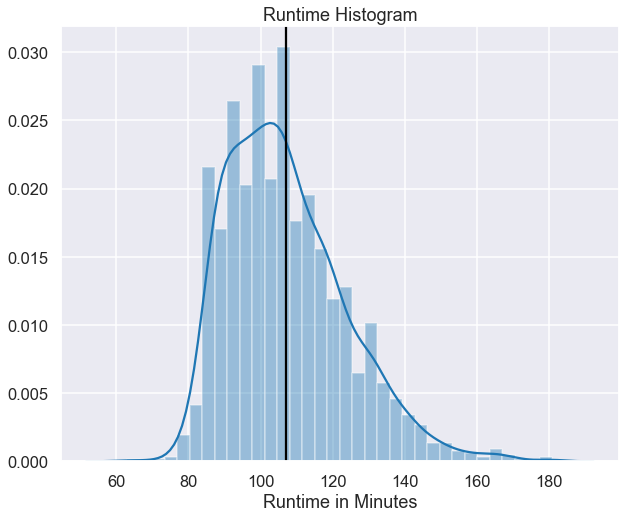

In [117]:
# Plotting a histogram
ax = sns.set_style("darkgrid")
ax = sns.set_context("talk")
ax = plt.figure(figsize = (10, 8))
ax = sns.distplot(runtime_gross_df['runtime_minutes'])
ax.set_title('Runtime Histogram')
ax.set_xlabel('Runtime in Minutes')
ax.axvline(runtime_gross_df['runtime_minutes'].mean(), color = 'black');

### Fig. 9 - Runtime vs. ROI in Top 100 Highest Grossing Films
The figure below represents the relationship between the length of the top 250 highest grossing movies and each movie's ROI.  Taking a look at the results, we see that, while close <b> the densest area of the scatterplot coincides with the area between 100 and 120 minutes in length. </b>  

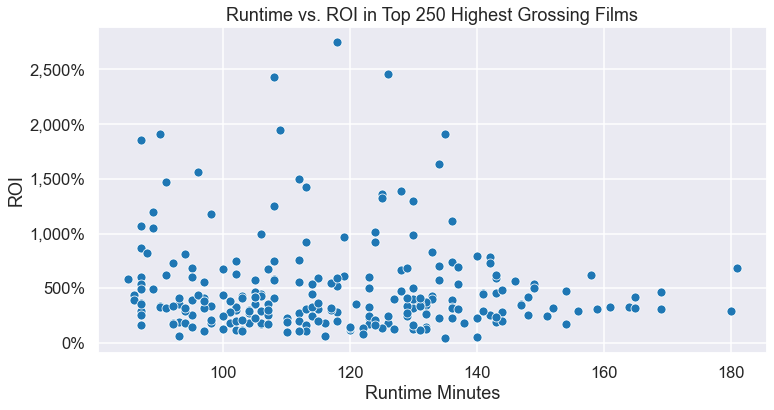

In [118]:
f,ax = plt.subplots(figsize = (12,6))
ax = sns.set_style("darkgrid")
ax = sns.set_context("talk")
ax = sns.scatterplot(x = 'runtime_minutes', y = 'ROI', ci = 68, data = runtime_gross_df.head(250));
ax.ticklabel_format(style='plain')
ax.set_title('Runtime vs. ROI in Top 250 Highest Grossing Films')
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('ROI')

fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick);

In [119]:
# Limiting dataframe to films longer than 100 minutes...

runtime_gross_df_new = runtime_gross_df[runtime_gross_df['runtime_minutes'] >= 100]
runtime_gross_df_new.shape

(1250, 5)

In [120]:
#...but shorter than 120 minutes

runtime_gross_df_new = runtime_gross_df_new[runtime_gross_df_new['runtime_minutes']<= 120]
runtime_gross_df_new.shape

(878, 5)

In [121]:
runtime_gross_df_new.head()

,primary_title,runtime_minutes,ww_gross,ROI,Net_Revenue
53,Frozen,102.00,1280802282.00,753.87,1130802282.00
670,Incredibles 2,118.00,1242805359.00,521.40,1042805359.00
1031,Toy Story 4,100.00,1073394593.00,436.70,873394593.00
1177,Toy Story 3,103.00,1066969703.00,433.48,866969703.00
1320,Alice in Wonderland,108.00,1025467110.00,412.73,825467110.00


In [122]:
runtime_gross_df_new = genre_revenue_df.groupby(runtime_gross_df_new['runtime_minutes'])['ROI'].median()

In [123]:
runtime_gross_df_new = runtime_gross_df_new.to_frame(name = 'ROI').reset_index()

In [124]:
runtime_gross_df_new = runtime_gross_df_new.sort_values('ROI', ascending = False) 

### Fig. 10 - Median ROI vs. Runtime Between 100 & 120 Minutes
To further narrow this down to find the perfect intersection of runtime and ROI, the figure below compares the Median ROI of films with a specific runtime between 100 and 120 minutes.  As we can see, <b> the highest ROI occurs when a film is 115 minutes long. </b>

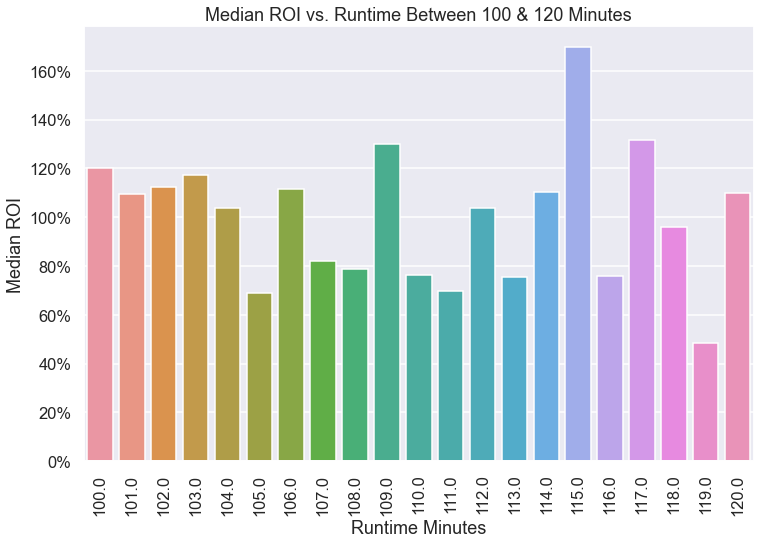

In [125]:
f,ax = plt.subplots(figsize = (12,8))
ax = sns.set_style("darkgrid")
ax = sns.set_context("talk")
ax = sns.barplot(x = 'runtime_minutes', y = 'ROI', data = runtime_gross_df_new)
ax.set_title('Median ROI vs. Runtime Between 100 & 120 Minutes')
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('Median ROI')

fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xticks(rotation = 90);

# Conclusion

Microsoft has recognized that other large tech corporations have found ample success in the film industry by producing their own original content.  The creation of the Microsoft Movie Studio will create an entirely new revenue stream for the company as well as provide many opportunities to synergize with existing Microsoft products.  However, with a high-dollar point of entry and Microsoft's sterling reputation on the line, this can also prove to be a risky venture.  How can we minimize this risk and maximize the return on investment by using a data-driven production system?

<h5>Throughout this notebook, we've answered the following questions:</h5>
 - Is there a correlation between a film's budget and it's performance at the box office?<br>
 - Do films in certain genres perform better at the box office?  If so, which genres?<br>
 - Is there a correlation between a film's MPAA rating and it's ROI?<br>
 - Does a film's runtime have any affect on it's worldwide gross?<br>
 
<h5>Based on the analysis provided above, I recommend taking the following actions:</h5>
 - The film should be made with a production budget of 183 million dollars. <br>
 - The genre of the film should be Animation. <br>
 - This film should be rated PG. <br>
 - This film should be 115 minutes in length. <br>
<br>

### Future Work
There are a variety of other aspects of this that I would like to tackle in the future.  These include: <br>
 - Are established film franchises more of a "sure-thing"?
 - Do major award nominations affect overal earnings?
 - Is it worth exploring creating and producing content for streaming platforms?

<center><h5> Thank you for your time. </h5> </center>